In [9]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
import pickle
import seaborn as sns
import datetime as dt
import yfinance as yf
import talib
from tqdm.notebook import tqdm
%matplotlib inline


class LinearModel:
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)
        self.vW = 0
        self.vb = 0
        self.losses = []

    def predict(self, s):
        return s.dot(self.W) + self.b

    def sgd(self, s, Y, learning_rate=0.001, momentum=0.9):
        num_values = np.prod(Y.shape)
        Y_hat = self.predict(s)
        Y_hat = self.predict(s)  # shape (1, 8)
        gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
        gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

        self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
        self.vb = momentum * self.vb - learning_rate * gb  # scalar

        self.W += self.vW  # vector shape (7, 8)
        self.b += self.vb  # scalar

        mse = np.mean((Y_hat - Y) ** 2)
        self.losses.append(mse)

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']


class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


class StockEnv:
    def __init__(self, data, capital, high,trade_fee_bid_percent=0.01, trade_fee_ask_percent=0.005):
        self.trade_fee_bid_percent = trade_fee_bid_percent / 100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent / 100  # percent

        self.stock_price_history = data['Adj Close']
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 5  # [stock price, stock_owned, cash__in_hand, rsi, mom]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0, 1]
        self.sell_buy = []
        self.save_stock_price = []
        self.rsi = data['rsi']
        self.mom = data['mom']
        self.cashflow = None
        self.high = high
        self.reset()

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi[self.current_step]
        vector[4] = self.mom[self.current_step]
        return vector

    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history[self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        self.cashflow = [0]
        return self.state_vector()

    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    

    def cal_position(self):
        mid_price = self.high / 2
        max_pos = self.capital / mid_price
        slope = max_pos / -self.high
        c = -slope * self.high

        return slope * self.stock_price + c, max_pos
    

    def trade(self, action):
        '''
        action 0 = hold
        action 1 = take action
        '''
        assert action in self.action_space

        if action == 1:
            position_sh, max_pos = self.cal_position()
            diff = position_sh - self.stock_owned
            if diff < 0:
                # sell
                self.stock_owned = position_sh
                self.cash_in_hand += (abs(diff) * self.stock_price * (1 - self.trade_fee_ask_percent))  
                
                cash_flow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                                    .5 * (max_pos + self.stock_owned) * self.stock_price)
                
                self.cash_in_hand -= cash_flow
                self.cashflow.append(cash_flow)
                self.sell_buy.append('sell')


            elif diff > 0:
                # buy
                self.stock_owned = position_sh
                self.cash_in_hand -= (abs(diff) * self.stock_price * (1 + self.trade_fee_bid_percent))
                
                cash_flow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                            .5 * (max_pos + self.stock_owned) * self.stock_price)
                
                self.cash_in_hand -= cash_flow
                self.cashflow.append(cash_flow)
                self.sell_buy.append('buy')

            else:
                self.cashflow.append(0)
                self.sell_buy.append('hold')

        else:
            self.cashflow.append(0)
            self.sell_buy.append('hold')

        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)

    def step(self, action):
        assert action in self.action_space

        prev_val = sum(self.cashflow)
        self.current_step += 1
        self.stock_price = self.stock_price_history[self.current_step]

        self.trade(action)
        current_val = sum(self.cashflow)
        reward = current_val - prev_val
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                #                 'current_val': self.port_val(),
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                'cashflow':self.cashflow
                }

        return self.state_vector(), reward, done, info


def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


def play_one_episode(agent, env, is_train, scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])

        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)

        state = next_state

    return info

In [10]:
stock_name = 'csco'.upper()
stock_data = pd.read_csv(f'../train_test_data/{stock_name}.csv', index_col=['Date'], parse_dates=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]

high = stock_data['Adj Close'].max()


num_episodes = 1000
batch_size = 32
capital = 1000
data = stock_data['Adj Close'].values
n_timesteps = data.shape[0]


env = StockEnv(train_data, capital, high)
state_size = env.state_dim
action_size = 2
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

  0%|          | 0/1000 [00:00<?, ?it/s]

episode: 1/1000, episode end value: 450.23, duration: 0:00:00.357093
episode: 2/1000, episode end value: 453.86, duration: 0:00:00.423094
episode: 3/1000, episode end value: 451.25, duration: 0:00:00.367070
episode: 4/1000, episode end value: 446.88, duration: 0:00:00.430102
episode: 5/1000, episode end value: 458.03, duration: 0:00:00.482096
episode: 6/1000, episode end value: 437.81, duration: 0:00:00.485108
episode: 7/1000, episode end value: 445.89, duration: 0:00:00.510101
episode: 8/1000, episode end value: 446.66, duration: 0:00:00.447106
episode: 9/1000, episode end value: 450.81, duration: 0:00:00.345077
episode: 10/1000, episode end value: 430.18, duration: 0:00:00.409091
episode: 11/1000, episode end value: 460.03, duration: 0:00:00.446100
episode: 12/1000, episode end value: 448.16, duration: 0:00:00.481108
episode: 13/1000, episode end value: 441.76, duration: 0:00:00.524118
episode: 14/1000, episode end value: 479.40, duration: 0:00:00.420106
episode: 15/1000, episode end

episode: 118/1000, episode end value: 449.49, duration: 0:00:00.442099
episode: 119/1000, episode end value: 446.33, duration: 0:00:00.447101
episode: 120/1000, episode end value: 422.62, duration: 0:00:00.431097
episode: 121/1000, episode end value: 423.96, duration: 0:00:00.442099
episode: 122/1000, episode end value: 438.31, duration: 0:00:00.495105
episode: 123/1000, episode end value: 446.71, duration: 0:00:00.524118
episode: 124/1000, episode end value: 430.59, duration: 0:00:00.493110
episode: 125/1000, episode end value: 437.45, duration: 0:00:00.472093
episode: 126/1000, episode end value: 444.35, duration: 0:00:00.444093
episode: 127/1000, episode end value: 436.50, duration: 0:00:00.464097
episode: 128/1000, episode end value: 461.56, duration: 0:00:00.485109
episode: 129/1000, episode end value: 459.90, duration: 0:00:00.514115
episode: 130/1000, episode end value: 440.88, duration: 0:00:00.473107
episode: 131/1000, episode end value: 450.72, duration: 0:00:00.412086
episod

episode: 234/1000, episode end value: 444.40, duration: 0:00:00.455095
episode: 235/1000, episode end value: 444.08, duration: 0:00:00.467111
episode: 236/1000, episode end value: 462.44, duration: 0:00:00.453102
episode: 237/1000, episode end value: 461.74, duration: 0:00:00.511115
episode: 238/1000, episode end value: 432.47, duration: 0:00:00.458096
episode: 239/1000, episode end value: 441.33, duration: 0:00:00.473106
episode: 240/1000, episode end value: 460.41, duration: 0:00:00.467105
episode: 241/1000, episode end value: 474.97, duration: 0:00:00.475094
episode: 242/1000, episode end value: 424.58, duration: 0:00:00.481114
episode: 243/1000, episode end value: 459.51, duration: 0:00:00.460104
episode: 244/1000, episode end value: 461.01, duration: 0:00:00.485108
episode: 245/1000, episode end value: 439.66, duration: 0:00:00.421088
episode: 246/1000, episode end value: 448.63, duration: 0:00:00.460139
episode: 247/1000, episode end value: 435.17, duration: 0:00:00.466092
episod

episode: 350/1000, episode end value: 429.95, duration: 0:00:00.500106
episode: 351/1000, episode end value: 439.01, duration: 0:00:00.485115
episode: 352/1000, episode end value: 432.47, duration: 0:00:00.505113
episode: 353/1000, episode end value: 429.45, duration: 0:00:00.472106
episode: 354/1000, episode end value: 425.32, duration: 0:00:00.490109
episode: 355/1000, episode end value: 431.86, duration: 0:00:00.488109
episode: 356/1000, episode end value: 429.30, duration: 0:00:00.492111
episode: 357/1000, episode end value: 435.60, duration: 0:00:00.498119
episode: 358/1000, episode end value: 438.19, duration: 0:00:00.484109
episode: 359/1000, episode end value: 439.37, duration: 0:00:00.485109
episode: 360/1000, episode end value: 456.13, duration: 0:00:00.479064
episode: 361/1000, episode end value: 450.89, duration: 0:00:00.490109
episode: 362/1000, episode end value: 430.91, duration: 0:00:00.485109
episode: 363/1000, episode end value: 443.73, duration: 0:00:00.511115
episod

episode: 466/1000, episode end value: 423.18, duration: 0:00:00.518102
episode: 467/1000, episode end value: 434.59, duration: 0:00:00.514128
episode: 468/1000, episode end value: 424.82, duration: 0:00:00.500112
episode: 469/1000, episode end value: 436.33, duration: 0:00:00.482108
episode: 470/1000, episode end value: 423.38, duration: 0:00:00.502150
episode: 471/1000, episode end value: 430.68, duration: 0:00:00.537121
episode: 472/1000, episode end value: 446.14, duration: 0:00:00.513115
episode: 473/1000, episode end value: 420.68, duration: 0:00:00.500117
episode: 474/1000, episode end value: 434.26, duration: 0:00:00.518109
episode: 475/1000, episode end value: 430.92, duration: 0:00:00.494110
episode: 476/1000, episode end value: 443.97, duration: 0:00:00.504113
episode: 477/1000, episode end value: 432.94, duration: 0:00:00.497112
episode: 478/1000, episode end value: 439.51, duration: 0:00:00.493110
episode: 479/1000, episode end value: 436.56, duration: 0:00:00.488101
episod

episode: 582/1000, episode end value: 442.14, duration: 0:00:00.492109
episode: 583/1000, episode end value: 438.40, duration: 0:00:00.511115
episode: 584/1000, episode end value: 429.93, duration: 0:00:00.471060
episode: 585/1000, episode end value: 424.77, duration: 0:00:00.506113
episode: 586/1000, episode end value: 414.30, duration: 0:00:00.499111
episode: 587/1000, episode end value: 427.21, duration: 0:00:00.515081
episode: 588/1000, episode end value: 425.73, duration: 0:00:00.509114
episode: 589/1000, episode end value: 447.49, duration: 0:00:00.516115
episode: 590/1000, episode end value: 439.32, duration: 0:00:00.504113
episode: 591/1000, episode end value: 430.92, duration: 0:00:00.504080
episode: 592/1000, episode end value: 463.06, duration: 0:00:00.500112
episode: 593/1000, episode end value: 449.61, duration: 0:00:00.484108
episode: 594/1000, episode end value: 429.84, duration: 0:00:00.497111
episode: 595/1000, episode end value: 439.63, duration: 0:00:00.504100
episod

episode: 698/1000, episode end value: 424.19, duration: 0:00:00.494104
episode: 699/1000, episode end value: 420.11, duration: 0:00:00.507100
episode: 700/1000, episode end value: 432.75, duration: 0:00:00.510129
episode: 701/1000, episode end value: 439.81, duration: 0:00:00.512121
episode: 702/1000, episode end value: 436.10, duration: 0:00:00.523124
episode: 703/1000, episode end value: 454.13, duration: 0:00:00.511108
episode: 704/1000, episode end value: 438.68, duration: 0:00:00.481101
episode: 705/1000, episode end value: 412.55, duration: 0:00:00.501112
episode: 706/1000, episode end value: 448.44, duration: 0:00:00.507112
episode: 707/1000, episode end value: 419.39, duration: 0:00:00.496111
episode: 708/1000, episode end value: 431.01, duration: 0:00:00.514115
episode: 709/1000, episode end value: 429.82, duration: 0:00:00.531081
episode: 710/1000, episode end value: 425.16, duration: 0:00:00.518116
episode: 711/1000, episode end value: 447.56, duration: 0:00:00.471085
episod

episode: 814/1000, episode end value: 432.90, duration: 0:00:00.440127
episode: 815/1000, episode end value: 424.56, duration: 0:00:00.512121
episode: 816/1000, episode end value: 436.14, duration: 0:00:00.470106
episode: 817/1000, episode end value: 417.73, duration: 0:00:00.515115
episode: 818/1000, episode end value: 431.16, duration: 0:00:00.521117
episode: 819/1000, episode end value: 442.61, duration: 0:00:00.520114
episode: 820/1000, episode end value: 411.89, duration: 0:00:00.520115
episode: 821/1000, episode end value: 427.67, duration: 0:00:00.515107
episode: 822/1000, episode end value: 412.25, duration: 0:00:00.528124
episode: 823/1000, episode end value: 440.10, duration: 0:00:00.509114
episode: 824/1000, episode end value: 431.94, duration: 0:00:00.489110
episode: 825/1000, episode end value: 454.83, duration: 0:00:00.509113
episode: 826/1000, episode end value: 423.75, duration: 0:00:00.493110
episode: 827/1000, episode end value: 437.59, duration: 0:00:00.523117
episod

episode: 930/1000, episode end value: 420.11, duration: 0:00:00.504128
episode: 931/1000, episode end value: 431.83, duration: 0:00:00.520117
episode: 932/1000, episode end value: 423.67, duration: 0:00:00.525119
episode: 933/1000, episode end value: 422.14, duration: 0:00:00.491108
episode: 934/1000, episode end value: 416.14, duration: 0:00:00.516115
episode: 935/1000, episode end value: 425.12, duration: 0:00:00.501113
episode: 936/1000, episode end value: 412.62, duration: 0:00:00.521110
episode: 937/1000, episode end value: 417.03, duration: 0:00:00.512114
episode: 938/1000, episode end value: 441.06, duration: 0:00:00.532112
episode: 939/1000, episode end value: 427.20, duration: 0:00:00.523117
episode: 940/1000, episode end value: 434.67, duration: 0:00:00.487104
episode: 941/1000, episode end value: 423.86, duration: 0:00:00.519115
episode: 942/1000, episode end value: 435.18, duration: 0:00:00.505113
episode: 943/1000, episode end value: 452.57, duration: 0:00:00.495112
episod

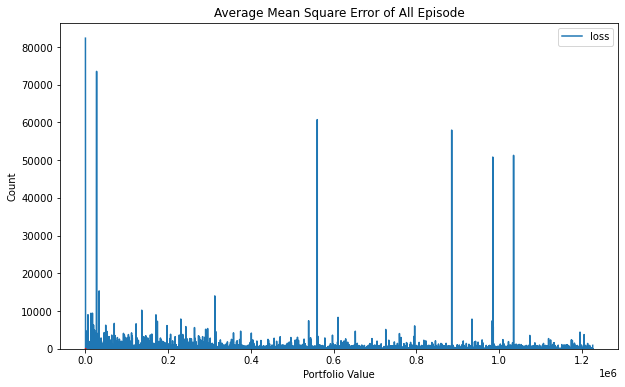

In [11]:
#train


mode = 'train'

cashflow = []



for e in tqdm(range(num_episodes)):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode, scaler)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {sum(val['cashflow']):.2f}, duration: {dt}")
    cashflow.append(sum(val['cashflow'])) 


if mode == 'train':
    # save the DQN
    agent.save(f'{stock_name}.npz')

    # save the scaler
    with open(f'{stock_name}.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
    loss = agent.model.losses
    losses = pd.DataFrame(loss, columns=['loss'])
    losses.plot(figsize=(10,6))
    plt.title('Average Mean Square Error of All Episode')
    plt.xlabel('Step')
    plt.ylabel('Mean Square Error')

print(f'average reward: {np.mean(cashflow):.2f}, min: {np.min(cashflow):.2f}, max: {np.max(cashflow):.2f}')
sns.histplot(cashflow, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

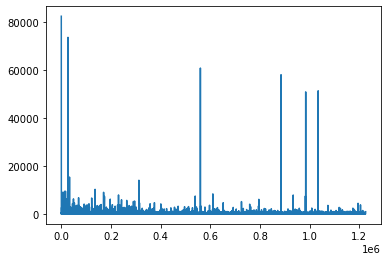

In [12]:
plt.plot(agent.model.losses)

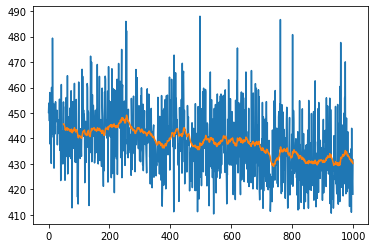

In [13]:
plt.plot(cashflow)
plt.plot(talib.EMA(np.array(cashflow), 50))

episode end value: 274.35, duration: 0:00:00.101023
Order: 748 times, Sell: 397 times, Buy: 351 times


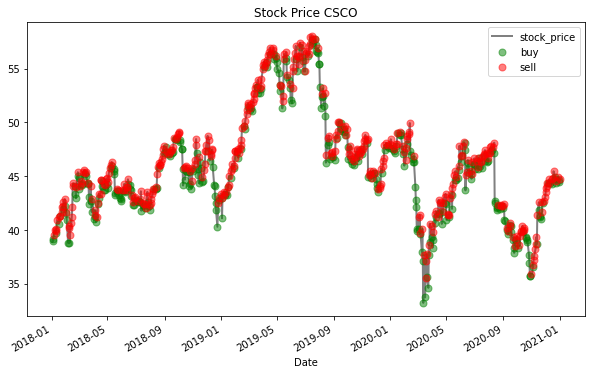

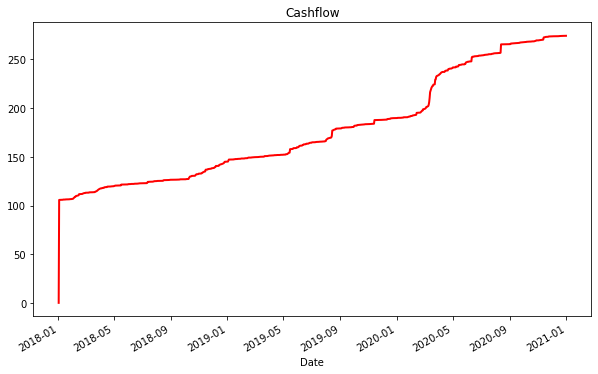

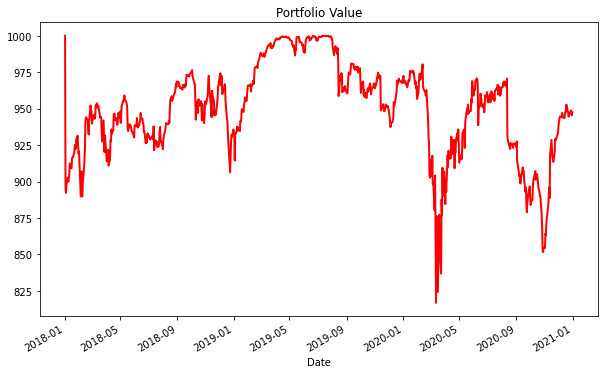

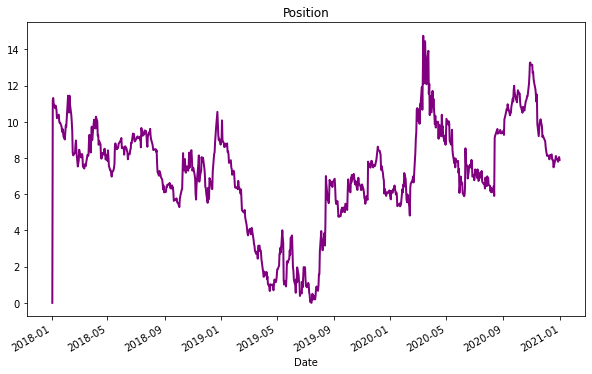

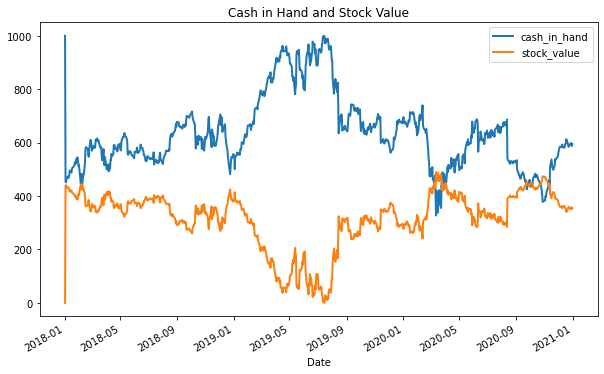

In [14]:
#test

mode = 'test'

cashflow = []


with open(f'{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
env = StockEnv(test_data, capital, high)
agent.epsilon = 0
agent.load(f'{stock_name}.npz')



t0 = datetime.now()
val = play_one_episode(agent, env, mode, scaler)
dt = datetime.now() - t0
print(f"episode end value: {sum(val['cashflow']):.2f}, duration: {dt}")
cashflow .append(sum(val['cashflow']))
    
print(f"Order: {env.sell_buy.count('sell') +env.sell_buy.count('buy')} times, Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")



result = pd.DataFrame(val)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['cashflow'].cumsum().plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()


result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

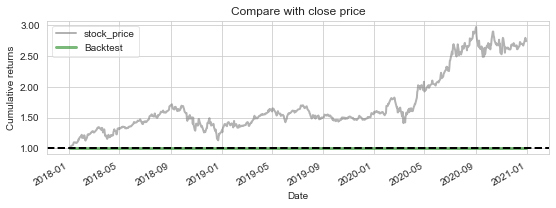

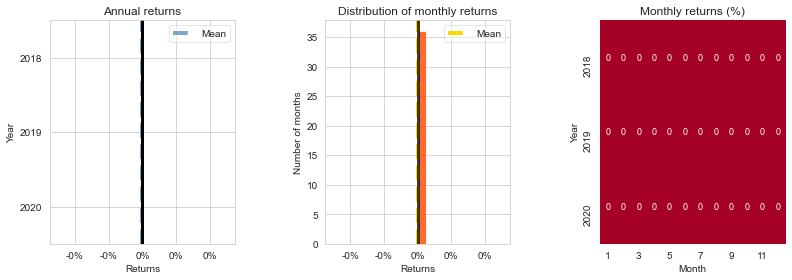

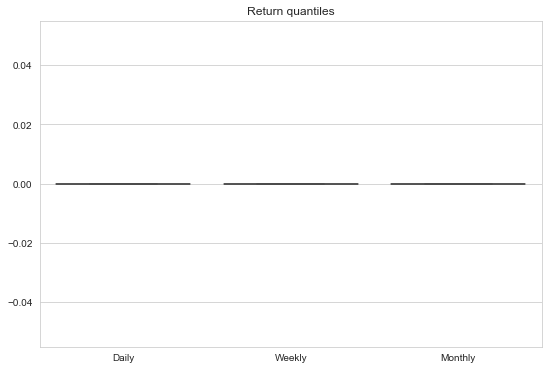

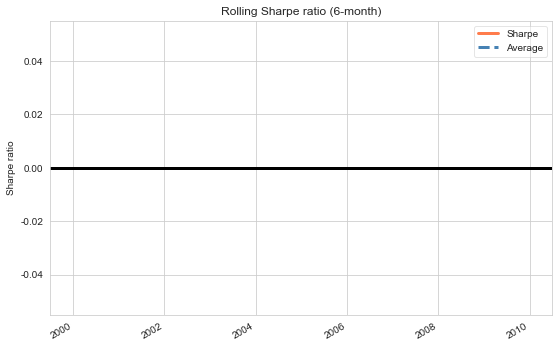

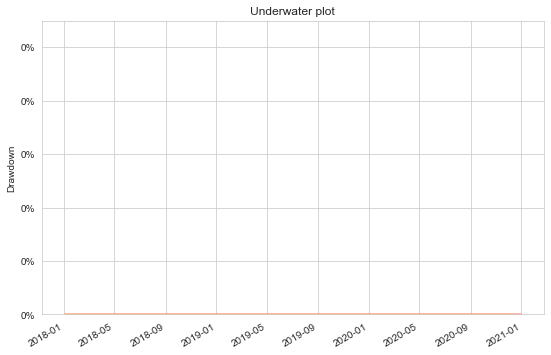

In [14]:
import pyfolio as pf
sns.set_style('whitegrid')

bt_returns = (result['portfolio_value'] + result['cashflow']).pct_change()
price = result['stock_price'].pct_change()



plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);